# Compare AEMO wind and sola observations with modelled

In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import string
letters = list(string.ascii_lowercase)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
%cd /g/data/w42/dr6273/work/power_models/

/g/data/w42/dr6273/work/power_models


In [3]:
year = "2023"

## Load modelled data

In [4]:
regions = ["NSW", "QLD", "VIC", "SA", "TAS"]

In [5]:
path_power = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/"

#### Wind and solar power

For REZs
- Current/planned generation capacities. These sometimes underestimate observed power (i.e. from installed farms) because it spreads the capacity around the REZ, rather than being loaded on a single grid cell.

In [6]:
def preprocess_2023(ds):
    """
    Select one year only
    """
    return ds.sel(time="2023")

In [205]:
def preprocess_2020_2023(ds):
    """
    Select 2020-2023
    """
    return ds.sel(time=slice("2020-12", "2023-11"))

In [206]:
wind_rez_current = xr.open_mfdataset(
    path_power + "REZ_power_existing_wind_van_der_Wiel_era5_hourly_1940-2023.nc",
    preprocess=preprocess_2020_2023
)

In [207]:
solar_rez_current = xr.open_mfdataset(
    path_power + "REZ_power_existing_solar_van_der_Wiel_era5_hourly_1940-2023.nc",
    preprocess=preprocess_2020_2023
)

We also use the power from farms outside the REZs, and add this to the REZ power

In [208]:
wind_outside_rez = xr.open_mfdataset(
    path_power + "site_outside_REZ_power_existing_wind_van_der_Wiel_era5_hourly_1940-2023.nc",
    preprocess=preprocess_2020_2023
).astype("float32")

In [209]:
solar_outside_rez = xr.open_mfdataset(
    path_power + "site_outside_REZ_power_existing_solar_van_der_Wiel_era5_hourly_1940-2023.nc",
    preprocess=preprocess_2020_2023
).astype("float32")

Add these together

In [210]:
def get_REZ_for_state(ds, state):
    """
    Return list of REZ names for state
    
    ds: dataset with REZ dimension
    state: str, code or for state e.g. NSW, SA
    """
    return [i for i in ds.REZ.values if i[0] == state[0]]

In [211]:
def sum_REZ_power_for_states(ds, states=["NSW", "QLD", "VIC", "SA", "TAS"]):
    """
    Return array of ds summed for each REZ in each state
    
    ds: dataset with REZ dimension
    states: list, of strings of states
    """
    da_list = []
    for state in states:
        r = get_REZ_for_state(ds, state)
        da = ds.sel(REZ=r).sum("REZ").expand_dims({"region": [state]})
        da_list.append(da)
    return xr.concat(da_list, dim="region")

In [212]:
wind_rez_current = sum_REZ_power_for_states(wind_rez_current) + wind_outside_rez

In [213]:
solar_rez_current = sum_REZ_power_for_states(solar_rez_current) + solar_outside_rez

Hack add TAS for solar to keep it same format as site power.

In [214]:
solar_tas = xr.DataArray(
    np.zeros(len(solar_rez_current.time)),
    dims=["time"],
    coords={"time": solar_rez_current.time}
).expand_dims({"region": ["TAS"]})

In [215]:
solar_rez_current = xr.concat([solar_rez_current.power, solar_tas], "region").to_dataset(name="power")

In [216]:
wind_rez_current = wind_rez_current.compute()

In [217]:
solar_rez_current = solar_rez_current.compute()

## Load AEMO data

In [218]:
def open_aemo_obs(fuel_type, year, months=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]):
    """
    Open monthly data and concatenate
    
    fuel_type: str, "wind" or "solar"
    year: str, year to open.
    months: list, each element a 2-character string indicating the month, e.g. '01', '02'.
    """
    df_list = []
    for month in months:
        df = pd.read_csv(
            "/scratch/w42/dr6273/processed_AEMO/aemo_hourly_" + fuel_type + "_" + year + "_" + month + ".csv",
            index_col=[0,1]
        )
        df_list.append(df)
        
    return pd.concat(df_list, axis=0)

In [219]:
def df_to_xarray(df):
    """
    Convert AEMO obs dataframe to xarray
    """
    # Convert to xarray DataSet
    ds = df.to_xarray()
    # Rename dimensions and variable name
    ds = ds.rename({"Region": "region", "SETTLEMENTDATE": "time", "INITIALMW": "power"})
    # Ensure coordinates are correct data type
    ds = ds.assign_coords({
        "region": ["NSW", "QLD", "SA", "TAS", "VIC"],
        "time": pd.to_datetime(ds["time"])
    })
    # Re-order region coordinate to match modelled data
    ds = ds.reindex({"region": ["NSW", "QLD", "VIC", "SA", "TAS"]})
    
    return ds

In [220]:
wind_list = []
solar_list = []

months=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

for year in ["2020", "2021", "2022", "2023"]:
    # We want December 2020 - November 2023
    if year == "2020":
        m = ["12"]
    elif year == "2023":
        m = months[:-1]
    else:
        m = months
        
    w = open_aemo_obs("wind", year, m)
    w_da = df_to_xarray(w).compute()
    wind_list.append(w_da)
    
    s = open_aemo_obs("solar", year, m)
    # Pad with NaNs for TAS
    s = s.reindex_like(w)
    s_da = df_to_xarray(s).compute()
    solar_list.append(s_da)

In [221]:
# aemo_wind = open_aemo_obs("wind", year)

In [222]:
# aemo_solar = open_aemo_obs("solar", year)
# # Pad with NaNs for TAS
# aemo_solar = aemo_solar.reindex_like(aemo_wind)

In [223]:
# aemo_wind = df_to_xarray(aemo_wind).compute()

In [224]:
# aemo_solar = df_to_xarray(aemo_solar).compute()

## Compare

In [225]:
aemo_wind = xr.concat(
    wind_list[:],
    dim="time"
)

In [226]:
aemo_wind_std = aemo_wind.power.std("time") * 4

In [227]:
aemo_wind_no_outliers = aemo_wind.where(aemo_wind.power <= aemo_wind.power.mean("time") + aemo_wind_std)

In [191]:
aemo_wind_no_outliers.isnull().sum("time")

<xarray.Dataset> Size: 100B
Dimensions:  (region: 5)
Coordinates:
  * region   (region) <U3 60B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
Data variables:
    power    (region) int64 40B 47 22 41 45 29

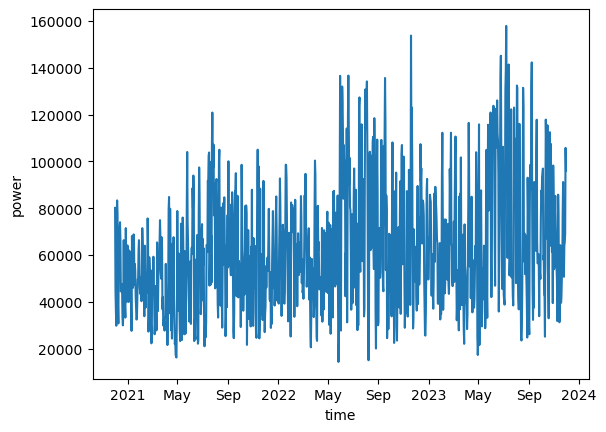

In [229]:
aemo_wind_no_outliers.power.sum("region").resample(time="1D").sum().plot()

In [230]:
aemo_solar = xr.concat(
    solar_list[:],
    dim="time"
)

In [231]:
aemo_solar_std = aemo_solar.power.std("time") * 4

In [232]:
aemo_solar_no_outliers = aemo_solar.where(aemo_solar.power <= aemo_solar.power.mean("time") + aemo_solar_std)

In [233]:
aemo_solar_no_outliers.isnull().sum("time")

<xarray.Dataset> Size: 100B
Dimensions:  (region: 5)
Coordinates:
  * region   (region) <U3 60B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
Data variables:
    power    (region) int64 40B 22 40 19 21 26280

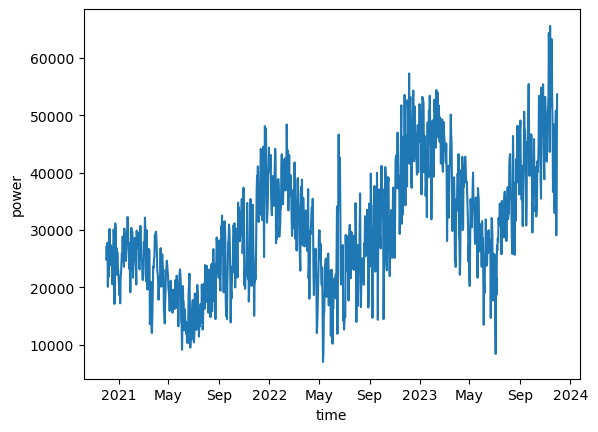

In [234]:
aemo_solar_no_outliers.power.sum("region").resample(time="1D").sum().plot()

In [235]:
def scatter(ax, region, fuel_type, obs, mod, energy_units, plot_daily=True, plot_monthly=True, add_legend=False, alpha=0.5):
    """
    Scatter plot obs against model
    
    ax: axes to plot on
    region: str, name of region
    fuel_type: str, name of fuel
    obs: array, observations
    mod: array: predictions
    energy_units: str, units to display
    plot_daily: bool, whether to plot daily values
    plot_monthly: bool, whether to plot monthly means
    add_legend: bool, whether to add legend
    """
    seas_months = [[12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]
    colors = ["tab:orange", "tab:blue", "tab:cyan", "tab:green"]
    labels = ["DJF", "MAM", "JJA", "SON"]
    markers = ["o", "d", "v", "s"]

    for months, color, label, marker in zip(
        seas_months, colors, labels, markers
    ):
        o = obs.isel(time=obs.time.dt.month.isin(months))
        m = mod.isel(time=mod.time.dt.month.isin(months))

        if plot_daily:
            ax.scatter(o, m, color=color, s=20, marker="o", alpha=alpha, label=label)
        
        if plot_monthly:
            if plot_daily:
                month_marker = "s"
            else:
                month_marker = "o"
                
            for month in months:
                if plot_daily:
                    m_obs = o.isel(time=o.time.dt.month == month).mean()
                    m_mod = m.isel(time=m.time.dt.month == month).mean()
                else:
                    m_obs = o.isel(time=o.time.dt.month == month).mean()
                    m_mod = m.isel(time=m.time.dt.month == month).mean()
                ax.scatter(m_obs, m_mod, color=color, s=50, marker=month_marker, edgecolor="k", zorder=3)

    if plot_daily:
        line_coords = np.arange(obs.min().min(), obs.max().max())
        ax.plot(line_coords, line_coords, color="k", zorder=4)

    ax.set_xlabel("Observed [" + energy_units + "]")
    ax.set_ylabel("Modelled [" + energy_units + "]")
    ax.set_title(region + ", " + fuel_type, loc="left", fontsize=10)
    
    if add_legend:
        cols = [Line2D([0], [0], marker='o', linestyle="None", color=c) for c in colors]
        
        if plot_monthly:
            if plot_daily:
                col1 = [Line2D([0], [0], marker='o', linestyle="None", color="tab:gray")]
                col2 = [Line2D([0], [0], marker=month_marker, linestyle="None", color="tab:gray")]
                blank = [Line2D([0], [0], marker=month_marker, linestyle="None", color="w")]
                cols = cols + blank + col1 + col2
                labels = labels + ["", "Daily", "Monthly"]

        ax.legend(cols, labels, frameon=False)

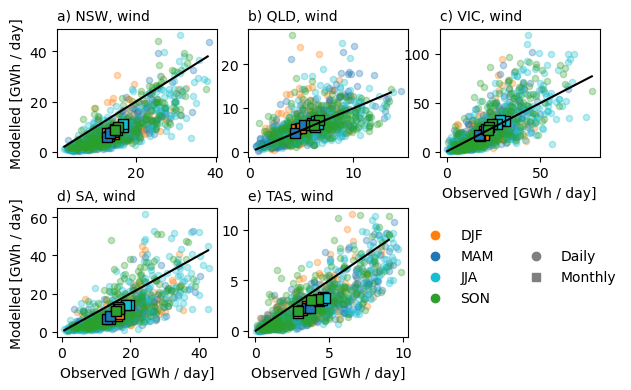

In [236]:
fig, ax = plt.subplots(2, 3, figsize=(7,4))

for i, region in enumerate(wind_rez_current.region.values):
    scatter(
        ax.flatten()[i],
        letters[i] + ") " + region,
        "wind",
        aemo_wind_no_outliers.sel(region=region)["power"].resample(time="1D").sum() / 1000,
        wind_rez_current.sel(region=region)["power"].sel(time=aemo_wind_no_outliers.time.values).resample(time="1D").sum() / 1000,
        "GWh / day",
        alpha=0.3
    )
    
    if i in [1, 2, 4, 5]:
        ax.flatten()[i].set_ylabel("")
    if i < 2:
        ax.flatten()[i].set_xlabel("")
        
ax[-1,-1].axis("off")
        
plt.subplots_adjust(hspace=0.4, wspace=0.2)

# Manual legend
cols = [Line2D([0], [0], marker='o', linestyle="None", color=c) for c in ["tab:orange", "tab:blue", "tab:cyan", "tab:green"]]
col1 = [Line2D([0], [0], marker='o', linestyle="None", color="tab:gray")]
col2 = [Line2D([0], [0], marker='s', linestyle="None", color="tab:gray")]
blank = [Line2D([0], [0], marker='s', linestyle="None", color="w")]
cols = cols + blank + col1 + col2
labels = ["DJF", "MAM", "JJA", "SON"]
labels = labels + ["", "Daily", "Monthly"]

ax[-1,-1].legend(cols, labels, ncols=2, frameon=False, loc=(-0.15, 0.2))

# plt.savefig("figures/model_wind_raw.pdf", format="pdf", bbox_inches="tight")

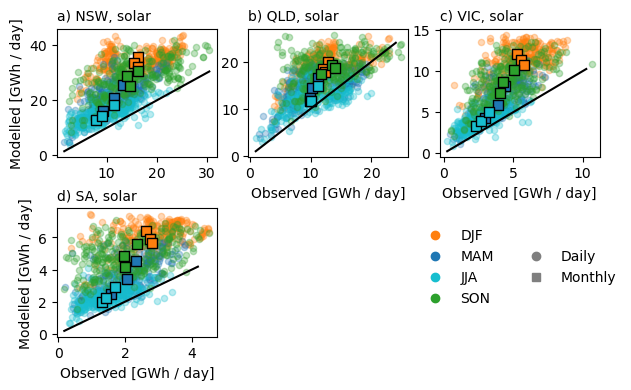

In [237]:
fig, ax = plt.subplots(2, 3, figsize=(7,4))

for i, region in enumerate(wind_rez_current.region.values):
    if i < 4:
        scatter(
            ax.flatten()[i],
            letters[i] + ") " + region,
            "solar",
            aemo_solar_no_outliers.sel(region=region)["power"].resample(time="1D").sum() / 1000,
            solar_rez_current.sel(region=region)["power"].sel(time=aemo_solar_no_outliers.time.values).resample(time="1D").sum() / 1000,
            "GWh / day",
            alpha=0.3
        )

        if i in [1, 2, 4, 5]:
            ax.flatten()[i].set_ylabel("")
        if i < 1:
            ax.flatten()[i].set_xlabel("")
        
ax[-1,-2].axis("off")
ax[-1,-1].axis("off")
        
plt.subplots_adjust(hspace=0.4, wspace=0.2)

# Manual legend
cols = [Line2D([0], [0], marker='o', linestyle="None", color=c) for c in ["tab:orange", "tab:blue", "tab:cyan", "tab:green"]]
col1 = [Line2D([0], [0], marker='o', linestyle="None", color="tab:gray")]
col2 = [Line2D([0], [0], marker='s', linestyle="None", color="tab:gray")]
blank = [Line2D([0], [0], marker='s', linestyle="None", color="w")]
cols = cols + blank + col1 + col2
labels = ["DJF", "MAM", "JJA", "SON"]
labels = labels + ["", "Daily", "Monthly"]

ax[-1,-1].legend(cols, labels, ncols=2, frameon=False, loc=(-0.15, 0.2))

# plt.savefig("figures/model_solar_raw.pdf", format="pdf", bbox_inches="tight")

### Find scaling factors for bias correction

In [238]:
# openNEM_solar_2023 = np.array([6368, 5845, 1546, 825, 0]) * 1000
# openNEM_wind_2023 = np.array([5754, 2605, 11076, 6304, 1890]) * 1000

In [251]:
wind_rez_scaled = wind_rez_current.assign_coords(
    # scale_factor_2023=("region", wind_rez_current.power.sum("time").values / openNEM_wind_2023)
    scale_factor_2023=(
        "region",
        aemo_wind.power.sel(time="2023").sum("time").values / wind_rez_current.power.sel(time="2023").sum("time").values
    )
)

In [252]:
solar_rez_scaled = solar_rez_current.assign_coords(
    # scale_factor_2023=("region", solar_rez_current.power.sum("time").values / openNEM_solar_2023)
    scale_factor_2023=(
        "region",
        aemo_solar.power.sel(time="2023").sum("time").values / solar_rez_current.power.sel(time="2023").sum("time").values
    )
)

/jobfs/145804285.gadi-pbs/ipykernel_92740/730290751.py:5: RuntimeWarning: invalid value encountered in divide
  aemo_solar.power.sel(time="2023").sum("time").values / solar_rez_current.power.sel(time="2023").sum("time").values


In [253]:
wind_rez_scaled.scale_factor_2023

<xarray.DataArray 'scale_factor_2023' (region: 5)> Size: 40B
array([2.00328505, 1.24217788, 1.14180519, 1.75572611, 1.46012224])
Coordinates:
  * region             (region) object 40B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
    scale_factor_2023  (region) float64 40B 2.003 1.242 1.142 1.756 1.46

In [254]:
solar_rez_scaled.scale_factor_2023

<xarray.DataArray 'scale_factor_2023' (region: 5)> Size: 40B
array([0.66037184, 0.94702117, 0.56261743, 0.57131687,        nan])
Coordinates:
  * region             (region) object 40B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
    scale_factor_2023  (region) float64 40B 0.6604 0.947 0.5626 0.5713 nan

In [255]:
wind_rez_scaled = wind_rez_scaled.power * wind_rez_scaled.scale_factor_2023
solar_rez_scaled = solar_rez_scaled.power * solar_rez_scaled.scale_factor_2023

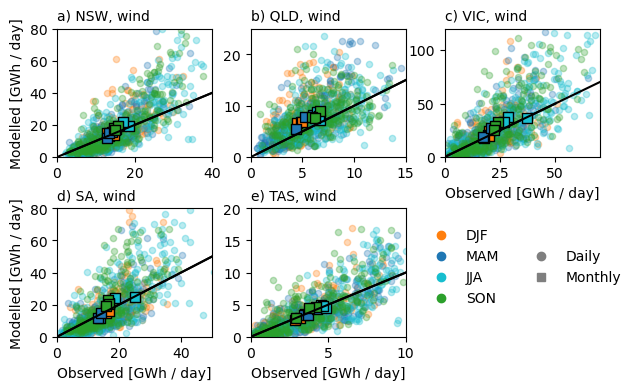

In [256]:
fig, ax = plt.subplots(2, 3, figsize=(7,4))

for i, region in enumerate(wind_rez_current.region.values):
    scatter(
        ax.flatten()[i],
        letters[i] + ") " + region,
        "wind",
        aemo_wind.sel(region=region)["power"].resample(time="1D").sum() / 1000,
        wind_rez_scaled.sel(region=region).resample(time="1D").sum() / 1000,
        "GWh / day",
        alpha=0.3,
        plot_daily=True,
        plot_monthly=True
    )
    
    if i in [1, 2, 4, 5]:
        ax.flatten()[i].set_ylabel("")
    if i < 2:
        ax.flatten()[i].set_xlabel("")
        
for a in ax.flatten()[:-1]:
    a.plot(range(51), range(51), c="k")
             
ax[0,0].set_xlim(0, 40)
ax[0,0].set_ylim(0, 80)

ax[0,1].set_xlim(0, 15)
ax[0,1].set_ylim(0, 25)

ax[0,2].set_xlim(0, 70)
ax[0,2].set_ylim(0, 120)

ax[1,0].set_xlim(0, 50)
ax[1,0].set_ylim(0, 80)

ax[1,1].set_xlim(0, 10)
ax[1,1].set_ylim(0, 20)

ax[-1,-1].axis("off")
        
plt.subplots_adjust(hspace=0.4, wspace=0.25)

# Manual legend
cols = [Line2D([0], [0], marker='o', linestyle="None", color=c) for c in ["tab:orange", "tab:blue", "tab:cyan", "tab:green"]]
labels = ["DJF", "MAM", "JJA", "SON"]
col1 = [Line2D([0], [0], marker='o', linestyle="None", color="tab:gray")]
col2 = [Line2D([0], [0], marker='s', linestyle="None", color="tab:gray")]
blank = [Line2D([0], [0], marker='s', linestyle="None", color="w")]
cols = cols + blank + col1 + col2
labels = ["DJF", "MAM", "JJA", "SON"]
labels = labels + ["", "Daily", "Monthly"]

ax[-1,-1].legend(cols, labels, ncols=2, frameon=False, loc=(-0.15, 0.2))

# plt.savefig("figures/model_wind_scaled.pdf", format="pdf", bbox_inches="tight")

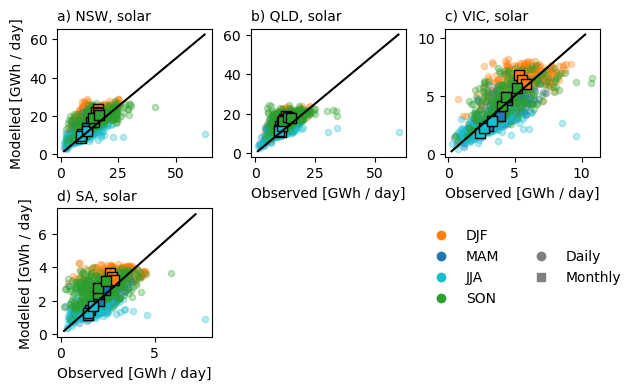

In [257]:
fig, ax = plt.subplots(2, 3, figsize=(7,4))

for i, region in enumerate(wind_rez_current.region.values):
    if i < 4:
        scatter(
            ax.flatten()[i],
            letters[i] + ") " + region,
            "solar",
            aemo_solar.sel(region=region)["power"].resample(time="1D").sum() / 1000,
            solar_rez_scaled.sel(region=region).resample(time="1D").sum() / 1000,
            "GWh / day",
            alpha=0.3
        )

        if i in [1, 2, 4, 5]:
            ax.flatten()[i].set_ylabel("")
        if i < 1:
            ax.flatten()[i].set_xlabel("")
        
ax[-1,-2].axis("off")
ax[-1,-1].axis("off")
        
plt.subplots_adjust(hspace=0.4, wspace=0.25)

# Manual legend
cols = [Line2D([0], [0], marker='o', linestyle="None", color=c) for c in ["tab:orange", "tab:blue", "tab:cyan", "tab:green"]]
col1 = [Line2D([0], [0], marker='o', linestyle="None", color="tab:gray")]
col2 = [Line2D([0], [0], marker='s', linestyle="None", color="tab:gray")]
blank = [Line2D([0], [0], marker='s', linestyle="None", color="w")]
cols = cols + blank + col1 + col2
labels = labels + ["", "Daily", "Monthly"]

ax[-1,-1].legend(cols, labels, ncols=2, frameon=False, loc=(-0.15, 0.2))

# plt.savefig("figures/model_solar_scaled.pdf", format="pdf", bbox_inches="tight")